In [1]:
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda:0


In [2]:
X_dim = 6
c_dim = 21
occ_dim = 121
y_dim = X_dim
z_dim = 5

bs = 256

## 读取dataset

In [3]:
from data.NarrowPassDataset import NarrowPassDataset

train_loader = DataLoader(NarrowPassDataset(csv_file = "data/NarrowPassage/narrowDataOcc.txt",
                            sample_dim = X_dim, 
                            condition_dim = c_dim,
                            occ_dim = occ_dim,
                            train = True),
                         batch_size = bs, shuffle=True)
test_loader = DataLoader(NarrowPassDataset(csv_file = "data/NarrowPassage/narrowDataOcc.txt",
                            sample_dim = X_dim, 
                            condition_dim = c_dim,
                            occ_dim = occ_dim,
                            train = True), 
                         batch_size = bs, shuffle=True)

## 定义模型

In [4]:
from models.CVAE import CVAE

model = CVAE(sample_size = 6, 
                  condition_size = occ_dim, 
                  encoder_layer_sizes = [512,1024,512], 
                  latent_size = z_dim, 
                  decoder_layer_sizes = [512,1024,512]).to(device)
print(model)

CVAE(
  (encoder): Encoder(
    (sequential): Sequential(
      (0): Linear(in_features=127, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): ReLU()
    )
    (linear_means): Linear(in_features=512, out_features=5, bias=True)
    (linear_log_var): Linear(in_features=512, out_features=5, bias=True)
  )
  (decoder): Decoder(
    (sequential): Sequential(
      (0): Linear(in_features=126, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): ReLU()
      (6): Linear(in_features=512, out_features=6, bias=True)
    )
  )
)


## loss function, optimizer

In [5]:
def loss_fn(recon_x, x, w, mean, log_var):
    MSE = torch.mean((w.expand_as(x) * (recon_x-x)**2))
    KLD = - 0.002 * torch.mean(torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), 1))
    return MSE + KLD, MSE

optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 训练

In [6]:
def train(epoch):
    model.train()
    train_loss = 0
    mse_loss = 0
    w = torch.tensor([1, 1, 1, 0.5, 0.5, 0.5], dtype=torch.float).to(device)
    for batch_idx, (sample, _, condition) in enumerate(train_loader):
        
        sample, condition = sample.to(device), condition.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(sample, condition)
        loss, mse= loss_fn(recon_batch, sample, w, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        mse_loss += mse.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(sample), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()))

    epoch_loss = train_loss * len(sample) / len(train_loader.dataset)
    epoch_mse = mse_loss * len(sample) / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.7f}'.format(
          epoch, epoch_loss))
    return epoch, epoch_loss, epoch_mse

In [7]:
epoch = 0
from visdom import Visdom
vis = Visdom(env='occ_deep_0.002')

loss_window = vis.line(
    Y=torch.zeros((1)).cpu(),
    X=torch.zeros((1)).cpu(),
    opts=dict(xlabel='epoch',ylabel='Loss',title='training loss',legend=['loss']))

In [8]:
for epoch in range(epoch, epoch + 500):
    log_interval = 100
    epoch, epoch_loss, epoch_mse = train(epoch)
    vis.line(X=torch.ones((1,1)).cpu()*epoch,Y=torch.Tensor([epoch_loss]).unsqueeze(0).cpu(),win=loss_window,update='append',name='loss')
    vis.line(X=torch.ones((1,1)).cpu()*epoch,Y=torch.Tensor([epoch_mse]).unsqueeze(0).cpu(),win=loss_window,update='append',name='mse_loss')
    

Train Epoch: 0 [0/66984 (0%)]	Loss: 0.272923
Train Epoch: 0 [25600/66984 (38%)]	Loss: 0.095399
Train Epoch: 0 [51200/66984 (76%)]	Loss: 0.088020
====> Epoch: 0 Average loss: 0.0639153
Train Epoch: 1 [0/66984 (0%)]	Loss: 0.075511
Train Epoch: 1 [25600/66984 (38%)]	Loss: 0.061821
Train Epoch: 1 [51200/66984 (76%)]	Loss: 0.057781
====> Epoch: 1 Average loss: 0.0394581
Train Epoch: 2 [0/66984 (0%)]	Loss: 0.055513
Train Epoch: 2 [25600/66984 (38%)]	Loss: 0.050940
Train Epoch: 2 [51200/66984 (76%)]	Loss: 0.047899
====> Epoch: 2 Average loss: 0.0329948
Train Epoch: 3 [0/66984 (0%)]	Loss: 0.047036
Train Epoch: 3 [25600/66984 (38%)]	Loss: 0.046937
Train Epoch: 3 [51200/66984 (76%)]	Loss: 0.044389
====> Epoch: 3 Average loss: 0.0307621
Train Epoch: 4 [0/66984 (0%)]	Loss: 0.043214
Train Epoch: 4 [25600/66984 (38%)]	Loss: 0.045610
Train Epoch: 4 [51200/66984 (76%)]	Loss: 0.047977
====> Epoch: 4 Average loss: 0.0302011
Train Epoch: 5 [0/66984 (0%)]	Loss: 0.045727
Train Epoch: 5 [25600/66984 (38%)]	

## 可视化结果

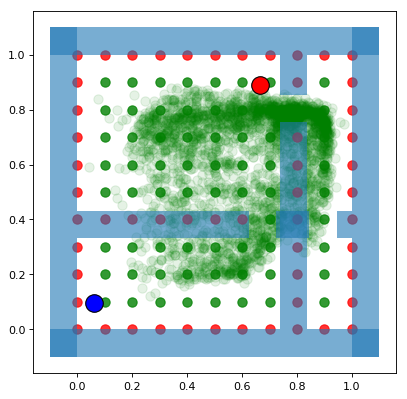

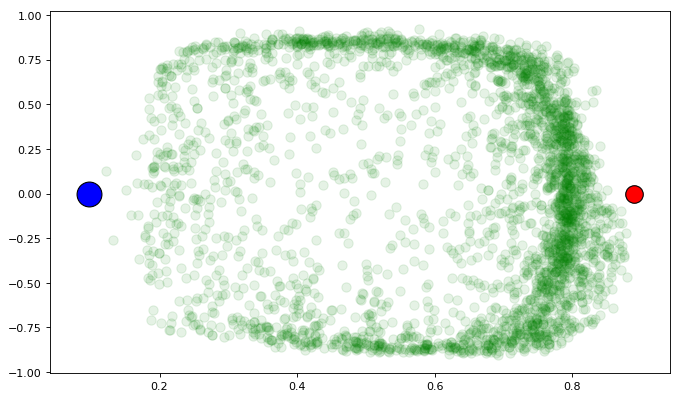

In [10]:
test_data = NarrowPassDataset(csv_file = "data/NarrowPassage/narrowDataOcc.txt",
                            sample_dim = X_dim, 
                            condition_dim = c_dim,
                            occ_dim = occ_dim,
                            train = False)
viz_idx =   torch.randint(0,len(test_data),[1]).item()  

# viz_idx = 8712

_, gap, condition = test_data[viz_idx]
condition = torch.tensor(condition)
model.eval()
num_viz = 3000
y_viz = model.decode(torch.cat((torch.randn(num_viz, z_dim).to(device),
                                condition.expand(num_viz, -1).to(device)),
                               dim=-1))

y_viz=y_viz.cpu().detach().numpy()
condition=condition.cpu().detach().numpy()

from utils.NarrowPassage import plotCondition, plotSample, plotSpeed

# plotCondition(condition)
plotSample(y_viz, gap)
plotSpeed(y_viz, gap)

In [11]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
torch.save(model.state_dict(), 'models/occ-deep-0.002.pt')

encoder.sequential.0.weight 	 torch.Size([512, 127])
encoder.sequential.0.bias 	 torch.Size([512])
encoder.sequential.2.weight 	 torch.Size([1024, 512])
encoder.sequential.2.bias 	 torch.Size([1024])
encoder.sequential.4.weight 	 torch.Size([512, 1024])
encoder.sequential.4.bias 	 torch.Size([512])
encoder.linear_means.weight 	 torch.Size([5, 512])
encoder.linear_means.bias 	 torch.Size([5])
encoder.linear_log_var.weight 	 torch.Size([5, 512])
encoder.linear_log_var.bias 	 torch.Size([5])
decoder.sequential.0.weight 	 torch.Size([512, 126])
decoder.sequential.0.bias 	 torch.Size([512])
decoder.sequential.2.weight 	 torch.Size([1024, 512])
decoder.sequential.2.bias 	 torch.Size([1024])
decoder.sequential.4.weight 	 torch.Size([512, 1024])
decoder.sequential.4.bias 	 torch.Size([512])
decoder.sequential.6.weight 	 torch.Size([6, 512])
decoder.sequential.6.bias 	 torch.Size([6])
